In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import data_preprocessing as dp
import utilities
import models.training as train

In [2]:
data, events = dp.load_data(subjects=range(1,11))
data, events = dp.choose_condition(data, events, 'inner speech')

In [3]:
f_data = dp.filter_interval(data, [1,3.5],256)
rf_data = f_data.reshape(len(f_data), 128*640)

In [4]:
print(f_data.shape)
print(rf_data.shape)

(2076, 128, 640)
(2076, 81920)


In [5]:
train_data = rf_data[:int(len(rf_data)*0.9)]

Standardizer. The standardizer is trained on the training data

In [6]:
scaler = StandardScaler()
scaler.fit(train_data)
strain_data = scaler.transform(train_data)
s_data = scaler.transform(rf_data)

PCA usually done with only train as well

Text(0, 0.5, 'Cumulative explained variance')

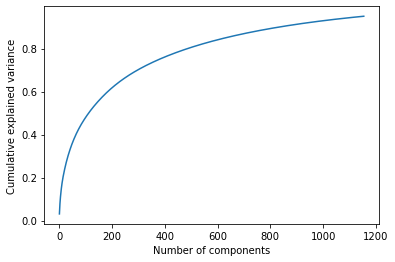

In [8]:
pca = PCA(n_components=0.95)
pca.fit(strain_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [9]:
pca_train_data = pca.transform(strain_data)
pca_data = pca.transform(s_data)
print(strain_data.shape)
print(pca_data.shape)

(1868, 81920)
(2076, 1155)


In [10]:
inv_pca = pca.inverse_transform(pca_data)
inv_sc = scaler.inverse_transform(inv_pca)

In [11]:
def side_by_side(indexes):
    org = rf_data[indexes].reshape(128,640)
    rec = inv_sc[indexes].reshape(128,640)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(10,8))
    plt.imshow(pair)
    plt.show()
def difference(indexes):
    org = rf_data[indexes].reshape(128,640)
    rec = inv_sc[indexes].reshape(128,640)
    diff = org-rec
    plt.figure(figsize=(5,4))
    plt.imshow(diff)
    plt.show()


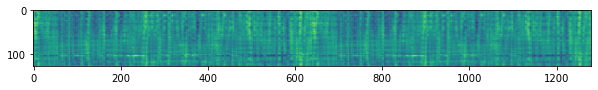

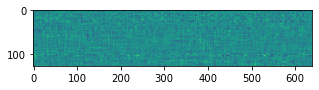

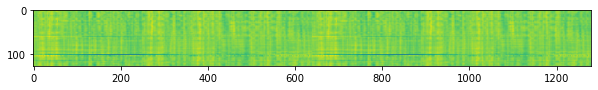

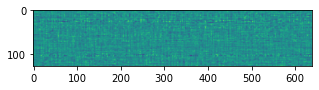

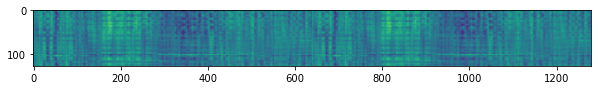

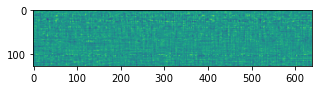

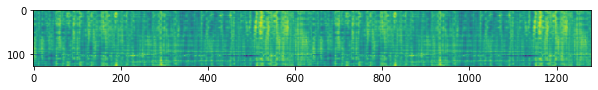

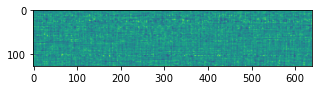

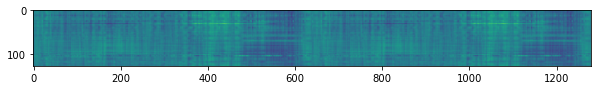

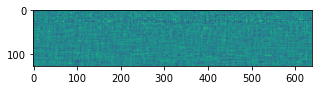

In [12]:
for index in range(0,5):
    side_by_side(index)
    difference(index)

Create tf.datasets

In [13]:
pca_comp = pca_data.shape[1]
print(pca_comp)

1155


In [14]:
dataset = tf.data.Dataset.from_tensor_slices((pca_data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 lambda sample: (tf.reshape(sample[0], (pca_comp, 1, 1)),
                                 sample[1])],
    args = [[], []],
    batch_size = 12
)

In [15]:
# split dataset
datasets = dp.split_dataset(dataset)

In [47]:

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D, LeakyReLU, MaxPool1D, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [48]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
labels = onehot_encoder.fit_transform(events[:,1].reshape(-1, 1))


In [49]:
print(pca_data.shape)
test = pca_data.reshape(pca_data.shape[0],pca_data.shape[1],1)
print(test.shape)

(2076, 1155)
(2076, 1155, 1)


In [78]:
model = Sequential()
layers = 2
pca_std = np.std(pca_train_data)

model.add(Dense(pca_comp, activation='relu'))
for i in range(layers):
    model.add(Conv1D(filters=16, kernel_size = 3))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

history = model.fit(test, labels, epochs=15, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/15
94/94 [==============================] - 15s 153ms/step - loss: 1.4518 - categorical_accuracy: 0.2548 - val_loss: 1.4050 - val_categorical_accuracy: 0.2500
Epoch 2/15
94/94 [==============================] - 16s 169ms/step - loss: 1.3921 - categorical_accuracy: 0.2489 - val_loss: 1.3955 - val_categorical_accuracy: 0.2596
Epoch 3/15
94/94 [==============================] - 14s 144ms/step - loss: 1.3881 - categorical_accuracy: 0.2559 - val_loss: 1.3852 - val_categorical_accuracy: 0.2788
Epoch 4/15
94/94 [==============================] - 17s 182ms/step - loss: 1.3903 - categorical_accuracy: 0.2495 - val_loss: 1.3907 - val_categorical_accuracy: 0.2163
Epoch 5/15
94/94 [==============================] - 18s 191ms/step - loss: 1.3873 - categorical_accuracy: 0.2661 - val_loss: 1.3926 - val_categorical_accuracy: 0.2163
Epoch 6/15
94/94 [==============================] - 13s 141ms/step - loss: 1.3866 - categorical_accuracy: 0.2537 - val_loss: 1.3861 - val_categorical_accuracy: 0.240

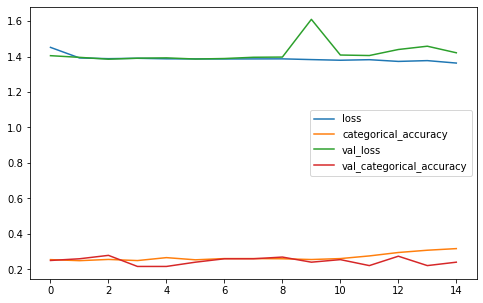

In [79]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()